In [1]:
import io
import requests
import numpy as np
import pandas as pd
import shinybroker as sb
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

In [2]:
asset_symbols = ['AAPL', 'MSFT', 'JPM', 'XOM', 'JNJ', 'PG', 'NVDA', 'CAT', 'HD', 'AMZN']

In [3]:
def calc_trd_prd(timestamps, freq = 'M'):
    if freq == 'W':
        return [ts.isocalendar()[0] + ts.isocalendar()[1] / 100 for ts in timestamps]
    elif freq == 'M':
        return [ts.year + ts.month / 100 for ts in timestamps]

# Collecting Data

In [14]:
import os

root = os.getcwd()
data_root = os.path.join(root, 'HistoryData')

if not os.path.exists(data_root):
    os.makedirs(data_root)
    print('HistoryData directory created')
else:
    print('HistoryData folder already exists')

daily_data_dict = {}
hourly_data_dict = {}
daily_iv_dict = {}
for symbol in asset_symbols:
    print(f"\n Fetching: {symbol}")

    contract = sb.Contract({
        'symbol': symbol,
        'secType': "STK",
        'exchange': "SMART",
        'currency': "USD"
    })

    df_daily = sb.fetch_historical_data(
        contract=contract,
        barSizeSetting="1 day",
        durationStr="8 M"
    )['hst_dta']

    df_hourly = sb.fetch_historical_data(
        contract=contract,
        barSizeSetting="1 hour",
        durationStr="8 M"
    )['hst_dta']

    df_daily_iv = sb.fetch_historical_data(
        contract=contract,
        barSizeSetting="1 day",
        durationStr="10 M",
        whatToShow="OPTION_IMPLIED_VOLATILITY"
    )['hst_dta']

    df_daily['trd_prd'] = calc_trd_prd(df_daily['timestamp'])
    df_hourly['trd_prd'] = calc_trd_prd(df_hourly['timestamp'])
    df_daily_iv['trd_prd'] = calc_trd_prd(df_daily_iv['timestamp'])

    df_daily.to_csv(os.path.join(data_root, f'{symbol}_daily.csv'))
    df_hourly.to_csv(os.path.join(data_root, f'{symbol}_hourly.csv'))
    df_daily_iv.to_csv(os.path.join(data_root, f'{symbol}_iv.csv'))

    daily_data_dict[symbol] = df_daily
    hourly_data_dict[symbol] = df_hourly
    daily_iv_dict[symbol] = df_daily_iv


print(daily_data_dict)
print(hourly_data_dict)
print(daily_iv_dict)



 Fetching: CAT

 Fetching: HD

 Fetching: AMZN
{'AAPL':       timestamp    open    high     low   close    volume      wap  barCount  \
0    2024-09-03  228.55  229.00  221.17  222.77  27800491  224.005    155414   
1    2024-09-04  221.70  221.78  217.48  220.85  27586896  219.774    142977   
2    2024-09-05  221.73  225.48  221.52  222.38  21549150  223.325    115868   
3    2024-09-06  224.00  225.24  219.77  220.82  26076978  221.990    133485   
4    2024-09-09  220.83  221.27  216.71  220.91  44734345  219.098    222732   
..          ...     ...     ...     ...     ...       ...      ...       ...   
160  2025-04-24  204.94  208.83  202.94  208.37  21895737  206.480    125147   
161  2025-04-25  206.35  209.75  206.20  209.28  19849630  208.137    108876   
162  2025-04-28  210.06  211.50  207.46  210.14  19037050  209.496    101542   
163  2025-04-29  208.80  212.24  208.37  211.21  16645097  210.940     91644   
164  2025-04-30  209.26  211.85  206.67  210.77  12048802  209.

# 10-2Yr Yield Spread

In [19]:
YYYY = [2024, 2025]
URL_lst = ['https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=' + 'daily_treasury_yield_curve&field_tdr_date_value=' + str(year) for year in YYYY]

df_yield_curve = pd.DataFrame()
for URL in URL_lst:
    cmt_rates_page = requests.get(URL)

    soup = BeautifulSoup(cmt_rates_page.content, 'html.parser')

    table_html = soup.findAll('table', {'class': 'views-table'})

    df = pd.read_html(io.StringIO(str(table_html)))[0]
    df.Date = pd.to_datetime(df.Date)
    # usdt_3mo_cmt = df.rename(columns={'3 Mo': '3_mo'})
    df_yield_curve = pd.concat([df_yield_curve, df])

df_yield_curve = df_yield_curve[['Date', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']]
df_yield_curve

,Date,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2024-01-02,5.54,5.46,5.41,5.24,4.80,4.33,4.09,3.93,3.95,3.95,4.25,4.08
1,2024-01-03,5.54,5.48,5.41,5.25,4.81,4.33,4.07,3.90,3.92,3.91,4.21,4.05
2,2024-01-04,5.48,5.48,5.41,5.25,4.85,4.38,4.14,3.97,3.99,3.99,4.30,4.13
3,2024-01-05,5.48,5.47,5.41,5.24,4.84,4.40,4.17,4.02,4.04,4.05,4.37,4.21
4,2024-01-08,5.48,5.49,5.39,5.24,4.82,4.36,4.11,3.97,3.99,4.01,4.33,4.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2025-04-23,4.34,4.33,4.33,4.22,4.01,3.81,3.87,4.00,4.20,4.40,4.86,4.83
77,2025-04-24,4.37,4.32,4.32,4.22,3.97,3.77,3.80,3.91,4.11,4.32,4.79,4.77
78,2025-04-25,4.36,4.32,4.32,4.22,3.95,3.74,3.76,3.88,4.06,4.29,4.75,4.74
79,2025-04-28,4.37,4.32,4.32,4.22,3.92,3.67,3.67,3.81,4.01,4.23,4.71,4.69


In [24]:
df_yield_spread = df_yield_curve.copy()
df_yield_spread['yield_spread'] = df_yield_spread.apply(lambda x: x['10 Yr']-x['2 Yr'], axis=1)
df_yield_spread = df_yield_spread[['Date', 'yield_spread']]
print(df_yield_spread)

         Date  yield_spread
0  2024-01-02         -0.38
1  2024-01-03         -0.42
2  2024-01-04         -0.39
3  2024-01-05         -0.35
4  2024-01-08         -0.35
..        ...           ...
76 2025-04-23          0.59
77 2025-04-24          0.55
78 2025-04-25          0.55
79 2025-04-28          0.56
80 2025-04-29          0.54

[331 rows x 2 columns]


# Calculate Indicators and Scores

In [20]:
def calculate_ema(prices, period=20):
    return prices.ewm(span=period, adjust=False).mean()


def calculate_macd(prices, fast=12, slow=26, signal=9):
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_diff = macd_line - signal_line
    return macd_diff


def calculate_adx(high, low, close, period=14):
    # Calculate True Range
    tr1 = abs(high - low)
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()

    # Calculate Plus Directional Movement (+DM) and Minus Directional Movement (-DM)
    plus_dm = high - high.shift(1)
    minus_dm = low.shift(1) - low
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm < 0] = 0

    # Condition when both +DM and -DM are greater than 0
    condition = (plus_dm > 0) & (minus_dm > 0)
    plus_dm[condition & (plus_dm < minus_dm)] = 0
    minus_dm[condition & (minus_dm < plus_dm)] = 0

    # Calculate Smoothed +DM and -DM
    smoothed_plus_dm = plus_dm.rolling(window=period).sum()
    smoothed_minus_dm = minus_dm.rolling(window=period).sum()

    # Calculate Smoothed TR
    smoothed_tr = atr * period

    # Calculate Plus Directional Indicator (+DI) and Minus Directional Indicator (-DI)
    plus_di = 100 * (smoothed_plus_dm / smoothed_tr)
    minus_di = 100 * (smoothed_minus_dm / smoothed_tr)

    # Calculate Directional Movement Index (DX)
    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))

    # Calculate Average Directional Index (ADX)
    adx = dx.rolling(window=period).mean()

    return adx


def calculate_atr(high, low, close, period=14):
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr


def calculate_iv_percentile(iv_series):
    percentile = (iv_series.rank(pct=True) * 100).iloc[-1]
    return percentile


def calculate_ema_score(price, ema20):
    delta = 100 * (price - ema20) / ema20

    # Calculate scores based on delta
    long_score = 0
    short_score = 0

    # Long score calculation
    if delta < -5:
        long_score = 5
    elif -5 <= delta < -3:
        long_score = 4
    elif -3 <= delta < -1:
        long_score = 3
    elif -1 <= delta < 0:
        long_score = 2

    # Short score calculation
    if delta > 5:
        short_score = 5
    elif 3 < delta <= 5:
        short_score = 4
    elif 1 < delta <= 3:
        short_score = 3
    elif 0 < delta <= 1:
        short_score = 2

    return long_score, short_score


def calculate_macd_score(macd_diff):
    long_score = 0
    short_score = 0

    # Long score calculation
    if macd_diff < -1.5:
        long_score = 5
    elif -1.5 <= macd_diff < -1:
        long_score = 4
    elif -1 <= macd_diff < -0.5:
        long_score = 3
    elif -0.5 <= macd_diff < -0.1:
        long_score = 2
    elif -0.1 <= macd_diff < 0:
        long_score = 1

    # Short score calculation
    if macd_diff > 1.5:
        short_score = 5
    elif 1 <= macd_diff <= 1.5:
        short_score = 4
    elif 0.5 <= macd_diff < 1:
        short_score = 3
    elif 0.1 <= macd_diff < 0.5:
        short_score = 2
    elif 0 <= macd_diff < 0.1:
        short_score = 1

    return long_score, short_score


def calculate_adx_score(adx):
    if adx <= 15:
        return 0
    elif 15 < adx <= 20:
        return 2
    elif 20 < adx <= 30:
        return 5
    elif 30 < adx <= 40:
        return 2
    else:  # adx > 40
        return 0


def calculate_atr_score(atr):
    if atr > 30:
        return 0
    elif 20 < atr <= 30:
        return 2
    elif 10 < atr <= 20:
        return 5
    elif 5 < atr <= 10:
        return 4
    else:  # atr < 5
        return 2


def calculate_iv_score(iv_percentile):
    long_score = 0
    short_score = 0

    if iv_percentile < 10:
        long_score = 5
        short_score = 0
    elif 10 <= iv_percentile < 30:
        long_score = 4
        short_score = 1
    elif 30 <= iv_percentile < 70:
        long_score = 2
        short_score = 2
    elif 70 <= iv_percentile < 90:
        long_score = 1
        short_score = 4
    else:  # iv_percentile >= 90
        long_score = 0
        short_score = 5

    return long_score, short_score


def calculate_yield_spread_score(yield_spread):
    long_score = 0
    short_score = 0

    if yield_spread > 1.5:
        long_score = 5
        short_score = 0
    elif 0.5 < yield_spread <= 1.5:
        long_score = 4
        short_score = 1
    elif -0.5 <= yield_spread <= 0.5:
        long_score = 2
        short_score = 2
    elif -1.5 <= yield_spread < -0.5:
        long_score = 1
        short_score = 4
    else:  # yield_spread < -1.5
        long_score = 0
        short_score = 5

    return long_score, short_score


def calculate_total_score(ema_long, ema_short, macd_long, macd_short, adx, atr, iv_long, iv_short, yield_long, yield_short):
    long_score = .25 * ema_long + .25 * macd_long + .1 * adx + .1 * atr + .15 * iv_long + .15 * yield_long
    short_score = .25 * ema_short + .25 * macd_short + .1 * adx + .1 * atr + .15 * iv_short + .15 * yield_short

    if long_score > short_score:
        return long_score, 'LONG'
    else:
        return -1*short_score, 'SHORT'

# Visualization

In [21]:
def plot_performance(ledger):
    plt.figure(figsize=(14, 7))
    plt.plot(ledger.index, ledger['Market Value'], label='End of Day Portfolio Market Value')
    plt.title('End of Day Portfolio Market Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Backtest Strategy Function

In [93]:
def backtest_strategy(daily_data_dict, hourly_data_dict, daily_iv_dict, df_yield_spread, asset_symbols, initial_capital=1_000_000, control_lever = False):
    # Ensure timestamps in df_yield_spread are in datetime format
    df_yield_spread['Date'] = pd.to_datetime(df_yield_spread['Date'])

    # Create asset blotters
    asset_blotter_dict = {}
    for asset in asset_symbols:
        blotter = pd.DataFrame(
            data={
                'entry_timestamp': None,
                'qty': 0,
                'exit_timestamp': None,
                'entry_price': None,
                'exit_price': None,
                'success': pd.NA
            },
            index=daily_data_dict[asset]['trd_prd'].unique()[2:]
        )
        asset_blotter_dict[asset] = blotter

    # Create portfolio blotter for rebalancing weights
    portfolio_periods = daily_data_dict[asset_symbols[0]]['trd_prd'].unique()[2:]
    print(f"backtest periods: {portfolio_periods}")
    portfolio_blotter_col = [f"{asset} weight" for asset in asset_symbols] +\
        [f"{asset} entry timestamp" for asset in asset_symbols] +\
        [f"{asset} exit timestamp" for asset in asset_symbols] +\
        [f"{asset} entry price" for asset in asset_symbols] +\
        [f"{asset} exit price" for asset in asset_symbols]
    portfolio_blotter = pd.DataFrame(index=portfolio_periods, columns=portfolio_blotter_col)
    portfolio_blotter.index.name = 'trd_prd'

    # Get all unique dates from the daily data for the ledger
    all_dates = []
    for asset in asset_symbols:
        # Ensure timestamp column is datetime
        daily_data_dict[asset]['timestamp'] = pd.to_datetime(daily_data_dict[asset]['timestamp'])
        # Extract dates
        portfolio_dates = daily_data_dict[asset][daily_data_dict[asset]['trd_prd']>=portfolio_periods[0]]['timestamp']
        all_dates.extend(portfolio_dates.dt.date.tolist())
    all_dates = sorted(list(set(all_dates)))

    # Create portfolio ledger with date index
    ledger_columns = ['Cash']
    for asset in asset_symbols:
        ledger_columns.append(f"{asset} Qty")
    for asset in asset_symbols:
        ledger_columns.append(f"{asset} Close")
    ledger_columns.extend(['Portfolio Value', 'Market Value'])

    ledger = pd.DataFrame(index=all_dates, columns=ledger_columns)
    ledger.index.name = 'Date'
    ledger['Cash'] = initial_capital
    for asset in asset_symbols:
        ledger[f"{asset} Qty"] = 0

    # Fill initial prices in ledger
    for date in all_dates:
        for asset in asset_symbols:
            mask = daily_data_dict[asset]['timestamp'].dt.date == date
            if mask.any():
                price_row = daily_data_dict[asset][mask]
                if not price_row.empty:
                    ledger.loc[date, f"{asset} Close"] = price_row['close'].values[0]

    # Process each trading period
    for period_idx, period in enumerate(portfolio_periods):
        # Get previous period for calculations
        prev_period = daily_data_dict[asset_symbols[0]]['trd_prd'].unique()[period_idx+1]
        prev_2_period = daily_data_dict[asset_symbols[0]]['trd_prd'].unique()[period_idx]
        print(f"Processing period: {period:.2f} Previous period: {prev_period:.2f}, Previous 2 period: {prev_2_period:.2f}")

        # Calculate indicators and weights for each asset
        asset_scores = {}
        total_score = 0

        for asset in asset_symbols:
            # Get data for previous period
            prev_data = daily_data_dict[asset][daily_data_dict[asset]['trd_prd'] <= prev_period]
            last_data = daily_data_dict[asset][daily_data_dict[asset]['trd_prd'] == prev_period]
            vol = last_data['close'].std()/100

            if prev_data.empty:
                continue

            # Calculate indicators
            last_close = prev_data['close'].iloc[-1]

            # EMA indicator
            ema20 = calculate_ema(prev_data['close'], 20).iloc[-1]
            ema_long, ema_short = calculate_ema_score(last_close, ema20)

            # MACD indicator
            macd_diff = calculate_macd(prev_data['close'], fast = 11, slow = 44, signal = 22).iloc[-1]
            macd_long, macd_short = calculate_macd_score(macd_diff)

            # ADX indicator
            adx = calculate_adx(prev_data['high'], prev_data['low'], prev_data['close'], period = 11).iloc[-1]
            adx_score = calculate_adx_score(adx)

            # ATR indicator
            atr = calculate_atr(prev_data['high'], prev_data['low'], prev_data['close'], period = 11).iloc[-1]
            atr_score = calculate_atr_score(atr)

            # IV indicator
            iv_window = daily_iv_dict[asset][
                (daily_iv_dict[asset]['trd_prd'] >= prev_2_period) &
                (daily_iv_dict[asset]['trd_prd'] <= period)
            ]['close'].dropna()


            iv_percentile = calculate_iv_percentile(iv_window)
            iv_long, iv_short = calculate_iv_score(iv_percentile)

            # Yield spread indicator
            # Use timestamp directly for comparison with datetime Series
            last_timestamp = prev_data['timestamp'].iloc[-1]
            yield_date_mask = df_yield_spread['Date'] <= last_timestamp

            if yield_date_mask.any():
                last_yield_date = df_yield_spread.loc[yield_date_mask, 'Date'].iloc[-1]
                yield_spread = df_yield_spread[df_yield_spread['Date'] == last_yield_date]['yield_spread'].values[0]
                yield_long, yield_short = calculate_yield_spread_score(yield_spread)
            else:
                yield_long, yield_short = 0, 0

            # Calculate total score and direction
            score, direction = calculate_total_score(
                ema_long, ema_short, macd_long, macd_short, adx_score, atr_score,
                iv_long, iv_short, yield_long, yield_short
            )


            # Store score, direction and ATR for stop loss/take profit
            asset_scores[asset] = {
                'score': score,
                'direction': direction,
                'atr': atr
            }

            total_score += score
        if control_lever:
            MAX_GROSS_LEVERAGE = 1.5 # maximum leverage (long + short)
            MAX_SINGLE_WEIGHT = 0.2 # upper limit of single equity weight

            long_group = {a: s['score'] for a, s in asset_scores.items() if s['score'] > 0}
            short_group = {a: -s['score'] for a, s in asset_scores.items() if s['score'] < 0}

            sum_long = sum(long_group.values())
            sum_short = sum(short_group.values())

            weights = {}
            # Independently Normalize:
            # long positions account for 60% of the total leverage
            # short positions account for 40% of the total leverage
            if sum_long > 0:
                for a in long_group:
                    weights[a] = (long_group[a] / sum_long) * (MAX_GROSS_LEVERAGE * 0.6)

            if sum_short > 0:
                for a in short_group:
                    weights[a] = -(short_group[a] / sum_short) * (MAX_GROSS_LEVERAGE * 0.4)

            # limit the maximum weight of a single stock.
            for a in weights:
                weights[a] = max(min(weights[a], MAX_SINGLE_WEIGHT), -MAX_SINGLE_WEIGHT)

            # re-adjust to restore the total leverage to 1.0
            gross = sum(abs(w) for w in weights.values())
            if gross > 1.0:
                weights = {a: w / gross for a, w in weights.items()}

        else:
            # Calculate weights
            weights = {}
            for asset in asset_scores:
                weight = asset_scores[asset]['score'] / abs(total_score)

                weights[asset] = weight

        for asset in asset_symbols:
            portfolio_blotter.loc[period, f'{asset} weight'] = weights.get(asset, 0.0)

        # Get first trading day of the period for each asset
        for asset in asset_symbols:
            if asset not in weights or asset not in asset_scores:
                continue

            # Get first trading day of the period
            period_daily_data = daily_data_dict[asset][daily_data_dict[asset]['trd_prd'] == period]
            period_hourly_data = hourly_data_dict[asset][hourly_data_dict[asset]['trd_prd'] == period]

            if period_daily_data.empty:
                continue

            entry_timestamp = period_hourly_data['timestamp'].iloc[0]
            entry_date = entry_timestamp.date()
            entry_price = period_daily_data['open'].iloc[0]

            # Get current portfolio value
            mask = [d <= entry_date for d in ledger.index]
            if any(mask):
                last_market_value = ledger.loc[mask, 'Market Value'].iloc[-1]
                if pd.isna(last_market_value):
                    # Use initial capital if no market value available yet
                    last_market_value = initial_capital
            else:
                last_market_value = initial_capital

            # Calculate target position
            target_value = weights[asset] * last_market_value
            target_qty = int(target_value / entry_price)

            # Update asset blotter
            asset_blotter_dict[asset].loc[period, 'entry_timestamp'] = entry_timestamp
            portfolio_blotter.loc[period, f'{asset} entry timestamp'] = entry_timestamp
            asset_blotter_dict[asset].loc[period, 'entry_price'] = entry_price
            portfolio_blotter.loc[period, f'{asset} entry price'] = entry_price
            asset_blotter_dict[asset].loc[period, 'qty'] = target_qty

            ledger_dates_entry = [d for d in ledger.index if d >= entry_date]
            ledger.loc[ledger_dates_entry, f"{asset} Qty"] = target_qty

            ledger.loc[ledger_dates_entry, 'Cash'] -= target_qty * entry_price



            # Process stop loss/take profit for this asset
            # Ensure hourly data timestamp is datetime
            hourly_data_dict[asset]['timestamp'] = pd.to_datetime(hourly_data_dict[asset]['timestamp'])
            period_hourly_data = hourly_data_dict[asset][hourly_data_dict[asset]['trd_prd'] == period]

            direction = asset_scores[asset]['direction']

            # Define stop loss/take profit levels
            if direction == 'LONG':
                stop_loss_level = entry_price * (1- vol)
                take_profit_level = entry_price * (1 + vol)
            else:  # SHORT
                stop_loss_level = entry_price * (1 +  vol)
                take_profit_level = entry_price* (1 -  vol)

            # Check for stop loss/take profit triggers
            exit_triggered = False
            exit_timestamp = None
            exit_price = None

            for _, row in period_hourly_data.iterrows():
                if direction == 'LONG':
                    # Check for take profit
                    if row['close'] >= take_profit_level:
                        exit_triggered = True
                        exit_timestamp = row['timestamp']
                        exit_price = row['close']
                        break
                    # Check for stop loss
                    elif row['close'] <= stop_loss_level:
                        exit_triggered = True
                        exit_timestamp = row['timestamp']
                        exit_price = row['close']
                        break
                else:  # SHORT
                    # Check for take profit
                    if row['close'] <= take_profit_level:
                        exit_triggered = True
                        exit_timestamp = row['timestamp']
                        exit_price = row['close']
                        break
                    # Check for stop loss
                    elif row['close'] >= stop_loss_level:
                        exit_triggered = True
                        exit_timestamp = row['timestamp']
                        exit_price = row['close']
                        break

            # If no exit triggered, use the last day of the period
            if not exit_triggered and not period_daily_data.empty:
                exit_timestamp = period_daily_data['timestamp'].iloc[-1]
                exit_price = period_daily_data['close'].iloc[-1]

            # Update asset blotter with exit information
            if exit_timestamp is not None and exit_price is not None:
                asset_blotter_dict[asset].loc[period, 'exit_timestamp'] = exit_timestamp
                portfolio_blotter.loc[period, f'{asset} exit timestamp'] = exit_timestamp
                asset_blotter_dict[asset].loc[period, 'exit_price'] = exit_price
                portfolio_blotter.loc[period, f'{asset} exit price'] = exit_price

                # Determine if trade was successful
                if direction == 'LONG':
                    success = exit_price > entry_price
                else:  # SHORT
                    success = exit_price < entry_price
                asset_blotter_dict[asset].loc[period, 'success'] = success

                # Update ledger for exit
                exit_date = exit_timestamp.date()

                # set the position quantity to 0 for all subsequent dates
                ledger_dates_exit = [d for d in ledger.index if d >= exit_date]
                ledger.loc[ledger_dates_exit, f"{asset} Qty"] = 0

                ledger.loc[ledger_dates_exit, 'Cash'] += target_qty * exit_price
        ledger = ledger.ffill()

    ledger['Cash'] = ledger['Cash'].ffill()

    for date in ledger.index:
        portfolio_value = 0
        for asset in asset_symbols:
            qty = ledger.loc[date, f"{asset} Qty"]
            price = ledger.loc[date, f"{asset} Close"]
            if not pd.isna(qty) and not pd.isna(price):
                portfolio_value += qty * price

        ledger.loc[date, 'Portfolio Value'] = portfolio_value
        ledger.loc[date, 'Market Value'] = ledger.loc[date, 'Cash'] + portfolio_value
    return asset_blotter_dict, portfolio_blotter, ledger

# Implement Startegy

backtest periods: [2024.11 2024.12 2025.01 2025.02 2025.03 2025.04]
Processing period: 2024.11 Previous period: 2024.10, Previous 2 period: 2024.09
Processing period: 2024.12 Previous period: 2024.11, Previous 2 period: 2024.10
Processing period: 2025.01 Previous period: 2024.12, Previous 2 period: 2024.11
Processing period: 2025.02 Previous period: 2025.01, Previous 2 period: 2024.12
Processing period: 2025.03 Previous period: 2025.02, Previous 2 period: 2025.01
Processing period: 2025.04 Previous period: 2025.03, Previous 2 period: 2025.02
=================== original (without controling lever) ===================


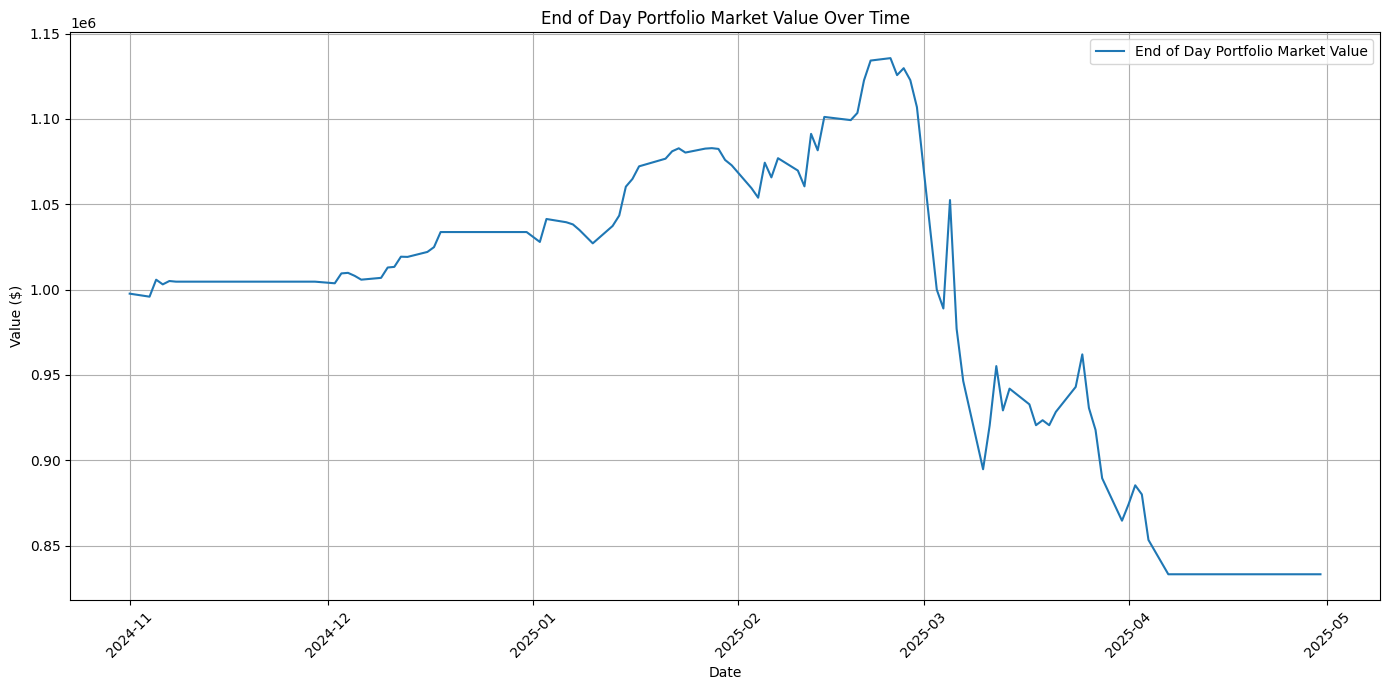

In [94]:
# Main execution
import warnings
warnings.filterwarnings('ignore')
asset_blotter_dict_original, portfolio_blotter_original, ledger_original = backtest_strategy(
    daily_data_dict, hourly_data_dict, daily_iv_dict, df_yield_spread, asset_symbols
)

# Plot performance
print("=================== original (without controling lever) ===================")
plot_performance(ledger_original)


# # Print summary
# print("\nPortfolio Blotter (Target Weights):")
# print(portfolio_blotter_original.head())
#
# print("\nSample Asset Blotter (AAPL):")
# print(asset_blotter_dict_original['AAPL'].head())
#
# print("\nLedger Sample:")
# print(ledger_original.head())
#
# print("\nFinal Portfolio Value:", ledger_original['Market Value'].iloc[-1])
#
portfolio_blotter_original.to_csv('blotter_original.csv')
ledger_original.to_csv('ledger_original.csv')

In [95]:
portfolio_blotter_original
# portfolio_blotter_original.sum(axis=1)

,AAPL weight,MSFT weight,JPM weight,XOM weight,JNJ weight,PG weight,NVDA weight,CAT weight,HD weight,AMZN weight,...,AAPL exit price,MSFT exit price,JPM exit price,XOM exit price,JNJ exit price,PG exit price,NVDA exit price,CAT exit price,HD exit price,AMZN exit price
trd_prd,,,,,,,,,,,,,,,,,,,,,
2024.11,0.106719,0.124506,-0.088933,0.118577,0.098814,0.13834,0.098814,0.156126,0.144269,0.102767,...,227.2,421.9,240.47,116.29,156.11,160.32,138.77,409.22,382.4,205.57
2024.12,-0.186246,-0.140401,-0.191977,0.143266,-0.106017,-0.200573,0.183381,-0.186246,-0.186246,-0.12894,...,250.14,443.94,234.0,111.69,146.64,169.56,146.08,385.24,397.82,221.54
2025.01,-0.126949,0.144766,0.113586,0.124722,0.091314,0.113586,0.142539,0.144766,0.131403,0.120267,...,234.89,415.06,256.01,106.83,154.01,157.79,143.93,386.36,416.46,235.07
2025.02,0.239583,0.354167,-0.348958,-0.213542,-0.3125,-0.239583,0.385417,-0.244792,-0.286458,-0.333333,...,247.02,396.99,264.65,111.33,163.25,173.84,124.05,343.95,396.6,215.77
2025.03,-0.522936,0.53211,0.477064,-0.422018,-0.559633,-0.633028,0.550459,0.495413,0.541284,0.541284,...,216.1,375.39,234.95,118.93,165.84,170.42,110.84,329.8,354.79,191.09
2025.04,0.228311,0.214612,-0.136986,-0.305936,0.182648,0.210046,0.30137,-0.200913,0.178082,0.328767,...,204.36,353.35,227.65,113.16,148.41,160.57,102.78,309.2,339.6,197.12


In [96]:
ledger_original

,Cash,AAPL Qty,MSFT Qty,JPM Qty,XOM Qty,JNJ Qty,PG Qty,NVDA Qty,CAT Qty,HD Qty,...,JPM Close,XOM Close,JNJ Close,PG Close,NVDA Close,CAT Close,HD Close,AMZN Close,Portfolio Value,Market Value
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-01,116385.68,482,304,-397,0,615,836,733,412,365,...,222.94,114.95,160.13,165.10,135.40,379.63,392.59,197.93,881274.46,997660.14
2024-11-04,116385.68,482,304,-397,0,615,836,733,412,365,...,219.78,118.61,158.24,165.08,136.05,376.52,395.57,195.78,879508.90,995894.58
2024-11-05,218104.09,482,304,-397,0,615,836,0,412,365,...,221.49,118.96,158.35,165.76,139.91,383.37,400.09,199.50,787739.11,1005843.20
2024-11-06,670913.78,482,304,0,0,615,0,0,0,0,...,247.06,121.00,157.88,161.05,145.61,416.88,388.37,207.09,332181.96,1003095.74
2024-11-07,908681.78,0,0,0,0,615,0,0,0,0,...,236.38,121.15,156.73,163.41,148.88,408.21,399.44,210.05,96388.95,1005070.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-24,833245.71,0,0,0,0,0,0,0,0,0,...,244.64,108.63,154.93,159.53,106.43,306.86,359.64,186.54,0.00,833245.71
2025-04-25,833245.71,0,0,0,0,0,0,0,0,0,...,243.55,108.57,154.58,161.02,111.01,306.45,357.58,188.99,0.00,833245.71
2025-04-28,833245.71,0,0,0,0,0,0,0,0,0,...,243.22,108.63,155.35,161.85,108.73,307.06,356.92,187.70,0.00,833245.71


# After Controlling Lever

backtest periods: [2024.11 2024.12 2025.01 2025.02 2025.03 2025.04]
Processing period: 2024.11 Previous period: 2024.10, Previous 2 period: 2024.09
Processing period: 2024.12 Previous period: 2024.11, Previous 2 period: 2024.10
Processing period: 2025.01 Previous period: 2024.12, Previous 2 period: 2024.11
Processing period: 2025.02 Previous period: 2025.01, Previous 2 period: 2024.12
Processing period: 2025.03 Previous period: 2025.02, Previous 2 period: 2025.01
Processing period: 2025.04 Previous period: 2025.03, Previous 2 period: 2025.02
=================== (after controling lever) ===================


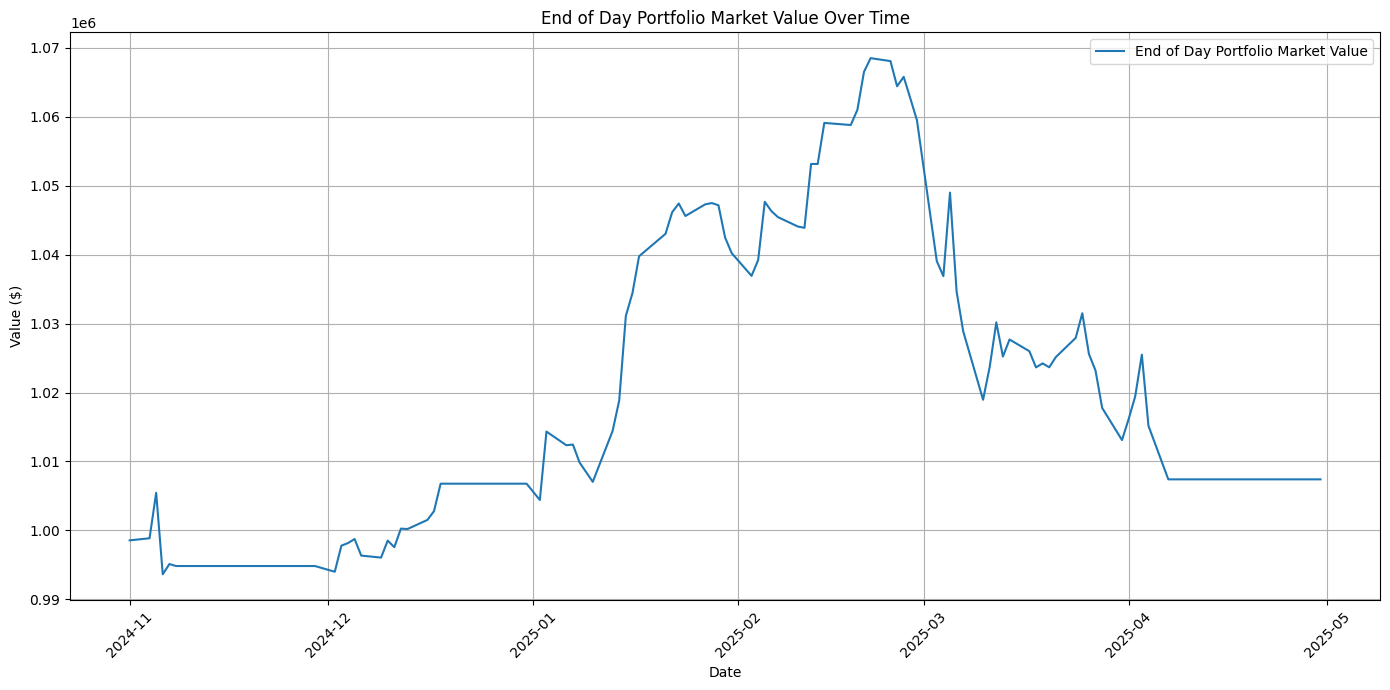


Portfolio Blotter (Target Weights):
        AAPL weight MSFT weight JPM weight XOM weight JNJ weight PG weight  \
trd_prd                                                                      
2024.11    0.080185    0.093549  -0.181818   0.089094   0.074245  0.103943   
2024.12   -0.084233   -0.063499  -0.086825        0.2  -0.047948 -0.090713   
2025.01   -0.181818    0.105102   0.082465    0.09055   0.066295  0.082465   
2025.02    0.166667    0.166667  -0.088158  -0.053947  -0.078947 -0.060526   
2025.03   -0.097854    0.101754   0.091228   -0.07897  -0.104721 -0.118455   

        NVDA weight CAT weight HD weight AMZN weight  ... AAPL exit price  \
trd_prd                                               ...                   
2024.11    0.074245   0.117307  0.108398    0.077215  ...           227.2   
2024.12         0.2  -0.084233 -0.084233   -0.058315  ...          250.14   
2025.01    0.103485   0.105102  0.095401    0.087316  ...          234.89   
2025.02    0.166667  -0.061842 

In [97]:
asset_blotter_dict_ctrl_lever, portfolio_blotter_ctrl_lever, ledger_ctrl_lever = backtest_strategy(
    daily_data_dict, hourly_data_dict, daily_iv_dict, df_yield_spread, asset_symbols, control_lever = True
)

print("=================== (after controling lever) ===================")

# Plot performance
plot_performance(ledger_ctrl_lever)
# Print summary
print("\nPortfolio Blotter (Target Weights):")
print(portfolio_blotter_ctrl_lever.head())

print("\nSample Asset Blotter (AAPL):")
print(asset_blotter_dict_ctrl_lever['AAPL'].head())

print("\nLedger Sample:")
print(ledger_ctrl_lever.head())

print("\nFinal Portfolio Value:", ledger_ctrl_lever['Market Value'].iloc[-1])

portfolio_blotter_ctrl_lever.to_csv('blotter_ctrl_lever.csv')
ledger_ctrl_lever.to_csv('ledger_ctrl_lever.csv')

In [98]:
portfolio_blotter_ctrl_lever
# portfolio_blotter_ctrl_lever.sum(axis=1)

,AAPL weight,MSFT weight,JPM weight,XOM weight,JNJ weight,PG weight,NVDA weight,CAT weight,HD weight,AMZN weight,...,AAPL exit price,MSFT exit price,JPM exit price,XOM exit price,JNJ exit price,PG exit price,NVDA exit price,CAT exit price,HD exit price,AMZN exit price
trd_prd,,,,,,,,,,,,,,,,,,,,,
2024.11,0.080185,0.093549,-0.181818,0.089094,0.074245,0.103943,0.074245,0.117307,0.108398,0.077215,...,227.2,421.9,240.47,116.29,156.11,160.32,138.77,409.22,382.4,205.57
2024.12,-0.084233,-0.063499,-0.086825,0.2,-0.047948,-0.090713,0.2,-0.084233,-0.084233,-0.058315,...,250.14,443.94,234.0,111.69,146.64,169.56,146.08,385.24,397.82,221.54
2025.01,-0.181818,0.105102,0.082465,0.09055,0.066295,0.082465,0.103485,0.105102,0.095401,0.087316,...,234.89,415.06,256.01,106.83,154.01,157.79,143.93,386.36,416.46,235.07
2025.02,0.166667,0.166667,-0.088158,-0.053947,-0.078947,-0.060526,0.166667,-0.061842,-0.072368,-0.084211,...,247.02,396.99,264.65,111.33,163.25,173.84,124.05,343.95,396.6,215.77
2025.03,-0.097854,0.101754,0.091228,-0.07897,-0.104721,-0.118455,0.105263,0.094737,0.103509,0.103509,...,216.1,375.39,234.95,118.93,165.84,170.42,110.84,329.8,354.79,191.09
2025.04,0.088346,0.083045,-0.090226,-0.141353,0.070677,0.081278,0.116617,-0.132331,0.06891,0.127218,...,204.36,353.35,227.65,113.16,148.41,160.57,102.78,309.2,339.6,197.12


In [99]:
ledger_ctrl_lever

,Cash,AAPL Qty,MSFT Qty,JPM Qty,XOM Qty,JNJ Qty,PG Qty,NVDA Qty,CAT Qty,HD Qty,...,JPM Close,XOM Close,JNJ Close,PG Close,NVDA Close,CAT Close,HD Close,AMZN Close,Portfolio Value,Market Value
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-01,451235.76,362,228,-813,0,462,628,551,310,274,...,222.94,114.95,160.13,165.10,135.40,379.63,392.59,197.93,547327.62,998563.38
2024-11-04,451235.76,362,228,-813,0,462,628,551,310,274,...,219.78,118.61,158.24,165.08,136.05,376.52,395.57,195.78,547626.05,998861.81
2024-11-05,527698.03,362,228,-813,0,462,628,0,310,274,...,221.49,118.96,158.35,165.76,139.91,383.37,400.09,199.50,477760.75,1005458.78
2024-11-06,744273.84,362,228,0,0,462,0,0,0,0,...,247.06,121.00,157.88,161.05,145.61,416.88,388.37,207.09,249366.24,993640.08
2024-11-07,922713.44,0,0,0,0,462,0,0,0,0,...,236.38,121.15,156.73,163.41,148.88,408.21,399.44,210.05,72409.26,995122.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-24,1007410.80,0,0,0,0,0,0,0,0,0,...,244.64,108.63,154.93,159.53,106.43,306.86,359.64,186.54,0.00,1007410.80
2025-04-25,1007410.80,0,0,0,0,0,0,0,0,0,...,243.55,108.57,154.58,161.02,111.01,306.45,357.58,188.99,0.00,1007410.80
2025-04-28,1007410.80,0,0,0,0,0,0,0,0,0,...,243.22,108.63,155.35,161.85,108.73,307.06,356.92,187.70,0.00,1007410.80


# Analyze

In [123]:
benchmark_data_daily = sb.fetch_historical_data(
        contract=sb.Contract({
        'symbol': "SPX",
        'secType': "IND",
        'exchange': "CBOE",
        'currency': "USD"
    }),
        barSizeSetting="1 day",
        durationStr="8 M"
    )['hst_dta'][['timestamp', 'close']].rename(columns = {'timestamp': 'Date'})
benchmark_data_daily

,Date,close
0,2024-09-05,5503.41
1,2024-09-06,5408.42
2,2024-09-09,5471.05
3,2024-09-10,5495.52
4,2024-09-11,5554.13
...,...,...
160,2025-04-28,5528.75
161,2025-04-29,5560.83
162,2025-04-30,5569.06
163,2025-05-01,5604.14


In [135]:
from sklearn.linear_model import LinearRegression
def performance_metrics(market_values, benchmark_values, trade_num, rf = 0.046):
    max_drawdown = 0.0
    peak_value = market_values.iloc[0]
    peak_time = market_values.index[0]
    trough_time = market_values.index[0]

    for t in market_values.index:
        value = market_values.loc[t]
        if value > peak_value:
            peak_value = value
            peak_time = t
        else:
            drawdown = (value - peak_value) / peak_value
            if drawdown < max_drawdown:
                max_drawdown = drawdown
                trough_time = t
    cumulative_return = market_values.iloc[-1] / market_values.iloc[0] - 1

    T_days = len(market_values)
    annualized_return = (market_values.iloc[-1] / market_values.iloc[0]) ** (252 / T_days) - 1
    # Geo Mean Return
    geo_mean_return = (1 + cumulative_return) ** (252 / T_days) - 1
    avg_return_per_trade = cumulative_return/trade_num

    daily_returns = market_values.pct_change().dropna()
    annualized_volatility = daily_returns.std() * np.sqrt(252)

    sharpe_ratio = (annualized_return-rf) / annualized_volatility

    max_one_day_drawdown = daily_returns.min()

    running_max = market_values.cummax()
    drawdowns = (market_values - running_max) / running_max

    if market_values.index.name == 'Date':
        market_values = market_values.reset_index()
    market_values['daily_return'] = market_values['Market Value'].pct_change()
    benchmark_values['benchmark_return'] = benchmark_values['close'].pct_change()
    ab_df = market_values[['Date', 'daily_return']].merge(benchmark_values[['Date', 'benchmark_return']], on='Date').dropna()
    # Alpha & Beta
    model = LinearRegression().fit(
        ab_df[["benchmark_return"]],
        ab_df["daily_return"]
    )
    alpha = model.intercept_
    beta = model.coef_[0]

    plt.figure(figsize=(12, 5))
    plt.plot(drawdowns, label='Max Drawdown')
    plt.title("Max Drawdown Over Time")
    plt.ylabel("Drawdown")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(market_values, label='Market Value')
    plt.title("Portfolio Market Value Over Time")
    plt.xlabel("Date")
    plt.ylabel("Market Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



    return {
        "alpha": alpha,
        "beta": beta,
        "Cumulative Return": [cumulative_return],
        "Geometric Mean Return": [geo_mean_return],
        "Average Return Per Trade": [avg_return_per_trade],
        "Annualized Volatility": [annualized_volatility],
        "Sharpe Ratio": [sharpe_ratio],
        "Max Drawdown": [max_drawdown],
        "Max One-Day Drawdown": [max_one_day_drawdown]
    }


================= Performance Before Controlling Lever =================


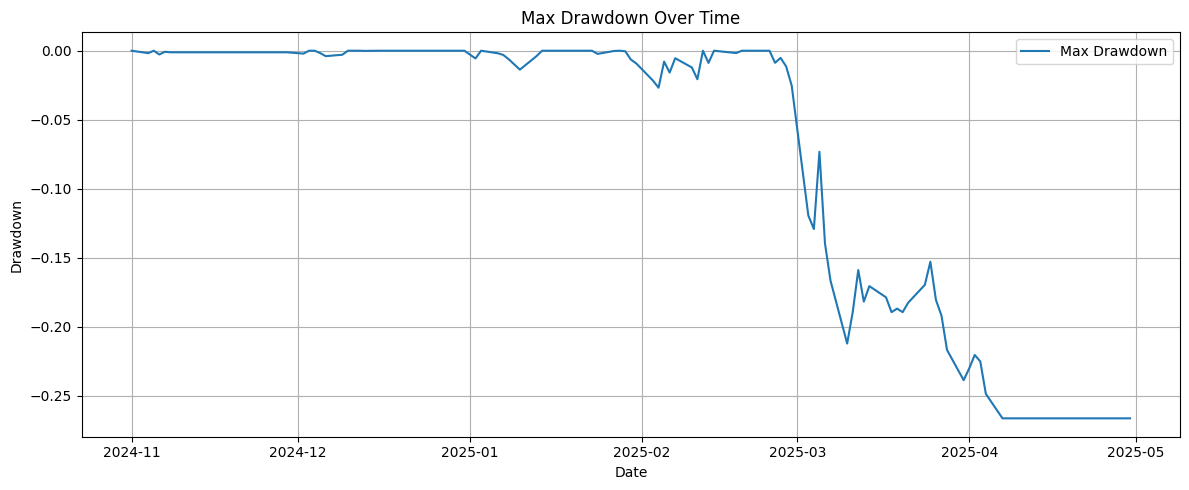

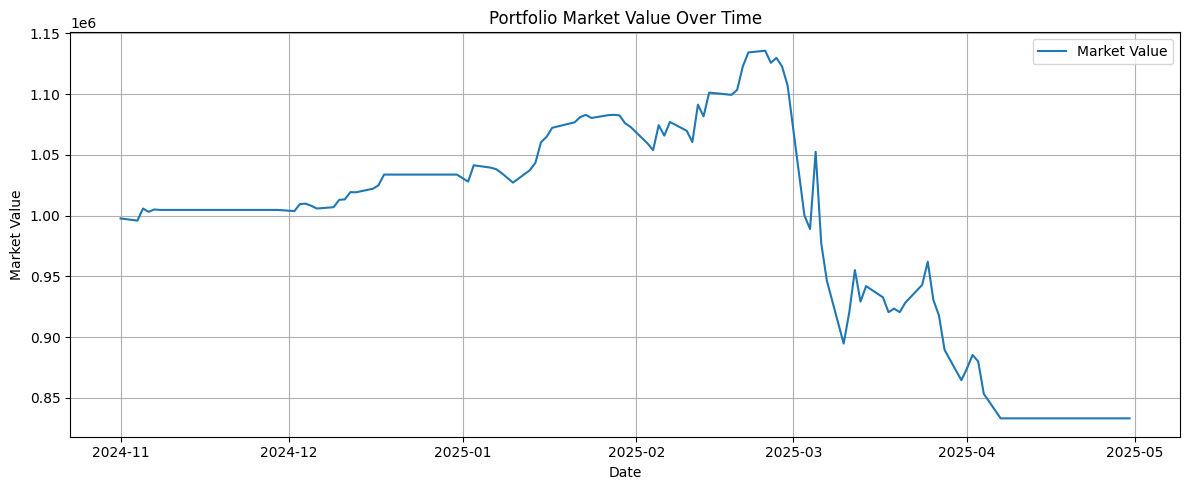

      alpha      beta  Cumulative Return  Geometric Mean Return  \
0 -0.001299  0.323833            -0.1648               -0.31063   

   Average Return Per Trade  Annualized Volatility  Sharpe Ratio  \
0                 -0.002747               0.272792     -1.138705   

   Max Drawdown  Max One-Day Drawdown  
0     -0.266284             -0.096578  
================= Performance After Controlling Lever =================


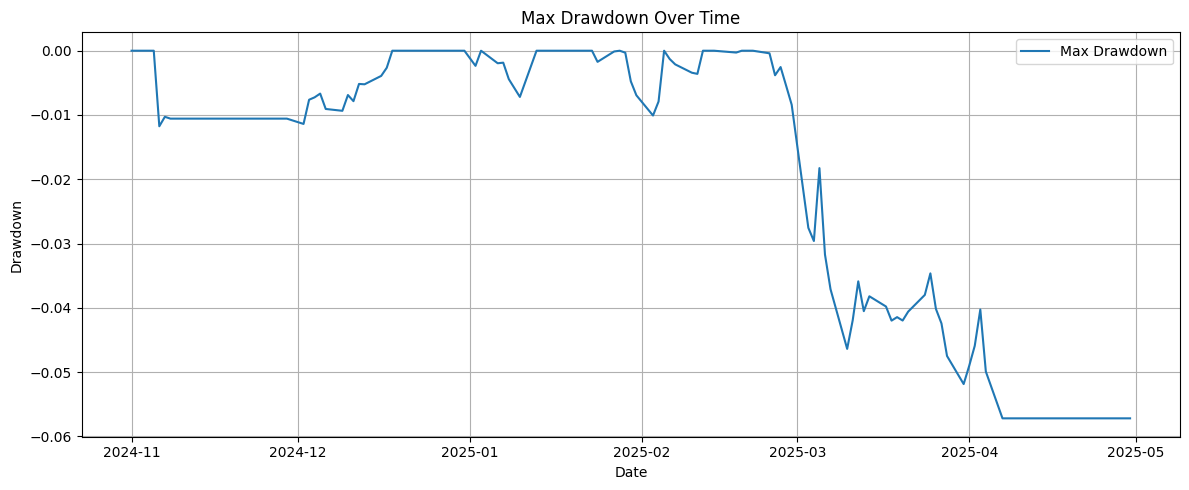

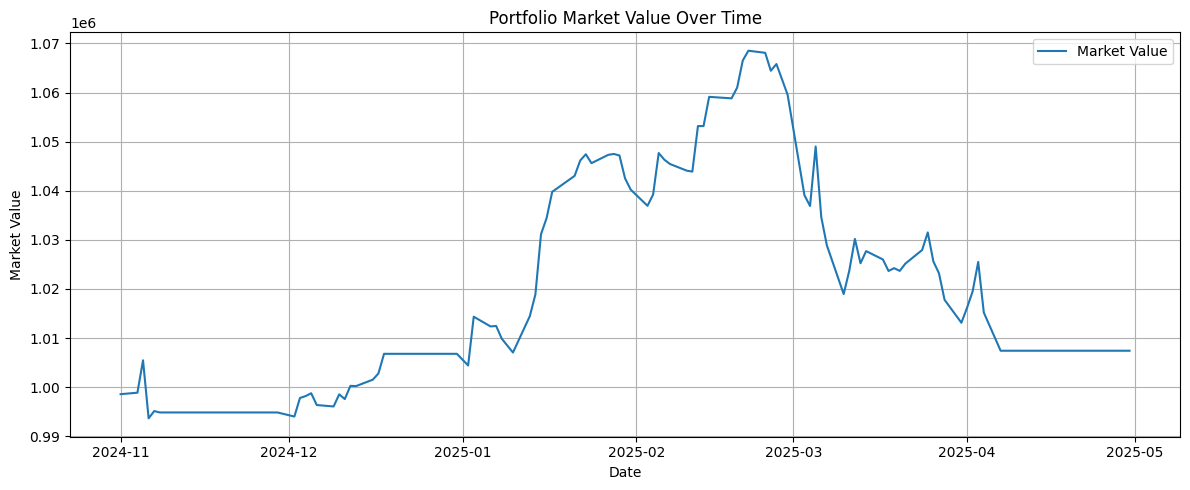

      alpha      beta  Cumulative Return  Geometric Mean Return  \
0  0.000089  0.062734            0.00886               0.018388   

   Average Return Per Trade  Annualized Volatility  Sharpe Ratio  \
0                  0.000148                0.06758      0.272088   

   Max Drawdown  Max One-Day Drawdown  
0     -0.057188             -0.019307  


In [136]:
print("================= Performance Before Controlling Lever =================")
metrics_original = performance_metrics(ledger_original['Market Value'], benchmark_values=benchmark_data_daily, trade_num = 6*10)
metrics_original = pd.DataFrame(metrics_original)
print(metrics_original)

print("================= Performance After Controlling Lever =================")
metrics_ctrl_lever = performance_metrics(ledger_ctrl_lever['Market Value'], benchmark_values=benchmark_data_daily, trade_num = 6*10)
metrics_ctrl_lever  = pd.DataFrame(metrics_ctrl_lever )
print(metrics_ctrl_lever)